# Apply AI Superresolution to video - Train VDSR from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors
- try vgg perception metric
- focus prediction



## Share results
- put out an example on youtube to allow comparison



# Project Documentation

In [1]:

project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train vdsr with hres perception loss multifuz-2.ipynb


In [4]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [5]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import os
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
from pathlib import Path
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale

import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [6]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [7]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".bmp"])



In [8]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [9]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data/train_data",1)

In [10]:
instances

[{'Filepath': '/media/SSD/superres/video_data/train_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/train_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/train_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/train_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/train_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/train_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/train_data/102797996.mp4',
  'Type': 'frame',
  'F

In [11]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [12]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [13]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        if self.size is not None:
            input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [14]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [15]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [16]:
class Crappify(object):


    def __init__(self, crop_size ,kernel_size, quality):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_size = kernel_size
        self.quality = quality

    
        

    def __call__(self, img):
        
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        k = Tophat2DKernel(int(self.kernel_size)/2.0).array
        k = k/k.sum()
        
        
        img_cv = cv2.filter2D(img_cv, -1, k)
    
        #Center Crop
        if self.crop_size is not None:
            img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,self.quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [17]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [18]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_range, quality_range, slope_range, radius_range, scale_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_range = kernel_range
        self.quality_range = quality_range
        self.slope_range = slope_range
        self.radius_range = radius_range
        self.scale_range = scale_range
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        rand_kernel = random.uniform(*self.kernel_range)
        rand_quality = random.uniform(*self.quality_range)
        rand_slope = random.uniform(*self.slope_range)
        rand_radius = random.uniform(*self.radius_range)*max(self.crop_size[0],self.crop_size[1])
        
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        rand_center = (random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom))
        
        rand_scale = random.uniform(0.5,2)
        #technically should adjust the scale to the crop size scale of the final image
        
        #blur kernel A
        
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        #blur kernel B
        rand_kernel = random.uniform(*self.kernel_range)
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=height, w=width, slope=rand_slope,center=rand_center, radius=rand_radius, scale = rand_scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (height,width,-1))
            alpha=np.broadcast_to(alpha,[height,width,3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        #img_cv = img_cv_blurA
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,rand_quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (720, 480)


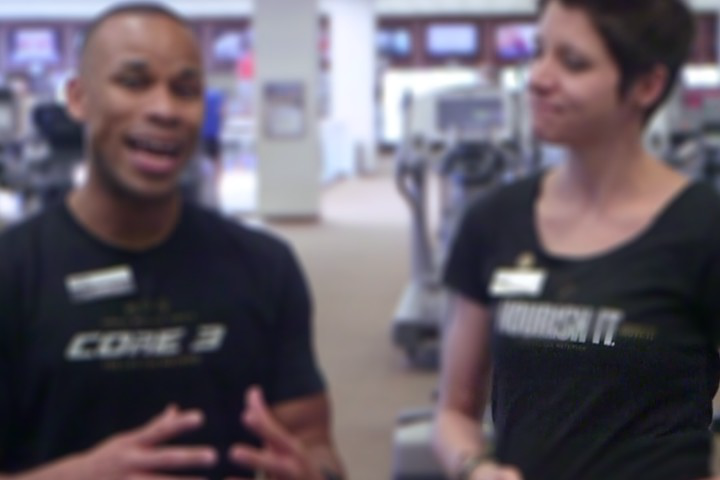

In [19]:
#test the CropRescale transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
#im_res = RescaleCrop(crop_size = (480,720), kernel_width=1)(im)
im_res = Multifuz(crop_size = (480,720),
                  kernel_range=(1,16), 
                  quality_range=(90,90), 
                  slope_range=(0.0001, 0.1),
                 radius_range=(.05,.5),
                 scale_range=(1/2,2))(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [20]:


def input_transform(crop_size, kernel_range):
    
    
    return Compose([
        
        Multifuz(crop_size = crop_size,
                  kernel_range=kernel_range, 
                  quality_range=(30,90), 
                  slope_range=(0.00001, 0.01),
                 radius_range=(.05,.75),
                 scale_range=(1/2,2)), 
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])



def test_input_transform(crop_size, kernel_size, quality):
    
    return Compose([
        Crappify(crop_size=crop_size, kernel_size=kernel_size, quality=quality),
        ToTensor()
    ])


def get_training_set(data_dir, crop_size, kernel_range, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, kernel_range),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, kernel_range):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, kernel_range,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, kernel_size, quality, frame_sample_size=10):


    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=test_input_transform(
                                 crop_size, kernel_size, quality),
                             target_transform=ToTensor(),
                             add_noise=None,
                             noise_std=3,Flip_hor=False,
                             Rand_bright_contrast=False)

In [21]:
train_dir = "/media/SSD/superres/video_data/train_data"
frame_sample_size =10
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
kernel_range=(1,20)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [22]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [23]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(480, 720)


In [24]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [25]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    print(inputs.shape)
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

torch.Size([4, 1, 480, 720])


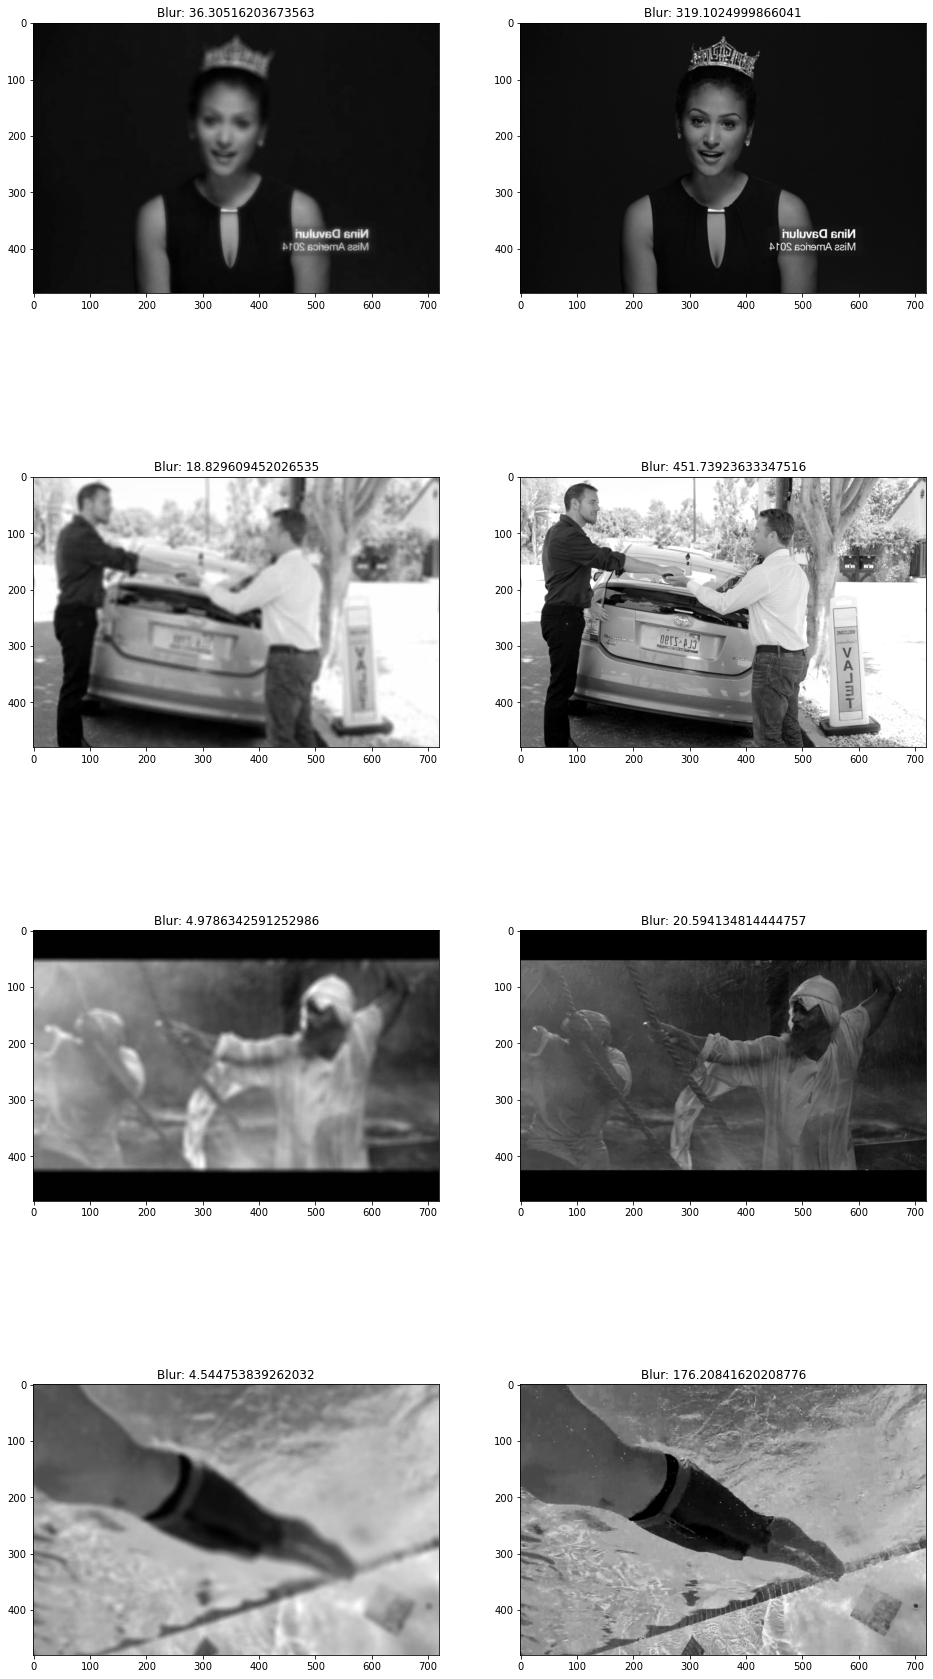

In [26]:
show_batch(training_data_loader,size =8)

# VDSR with dropout

In [ ]:
import torch.nn as nn
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.do = nn.Dropout2d(p=0.5, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out

# Build the model

In [ ]:
model = Net()
model.cuda()


In [27]:
model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]



/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original sourc

In [ ]:
model

In [28]:
criterion2 = nn.MSELoss(reduction = 'sum')
#criterion = nn.L1Loss(reduction = 'sum')

#loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
#loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

loss_fn = lpips.LPIPS(net='alex')
loss_fn.cuda()

def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [29]:
class P_Loss(torch.nn.Module):
    
    def __init__(self):
        super(P_Loss,self).__init__()
        
    def forward(self,x,y):
        
        totloss = torch.mean(loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        
        # approach to split image into blocks since loss works on 256x256 images
        for i in [0, 224]:
            for j in [0, 232, 464 ]:
                x_crop = x[:,:,i:i+255, j:j+255]
                y_crop = y[:,:,i:i+255, j:j+255]
                totloss.add_(torch.mean(loss_fn.forward(loss_scaler(x_crop),loss_scaler(y_crop)))/6)
        
        #print("before:",totloss)
        
        #also use mse loss
        #totloss.add_(torch.mean(loss_fn_2.forward(x,y)))
        
        #print("after:",totloss)
        #do we need to work in color?
        
        return totloss

In [30]:
list(range(0,1280-256,256-int((256*6-1280)/5)))

[0, 205, 410, 615, 820]

In [31]:
list(range(0,720-256,256-int((256*3-720)/2)))

[0, 232]

In [32]:
criterion = P_Loss()

#criterion.cuda()

In [33]:
init_lr = 0.1/100
lr_step = 3
gradient_clip = 0.4
epochs = 12

In [34]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)

In [35]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [36]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [37]:
def save_checkpoint(model, epoch):
    model_out_path = "checkpoint/" + "hresperfuzmodel2_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("checkpoint/"):
        os.makedirs("checkpoint/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [38]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [39]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()
        
        # Runs the forward pass with autocasting.
        with autocast():
            output = model(input)
            loss = criterion(output, target) + criterion2(output, target)/10000.0
            
        
        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
    print("Epoch Loss:", cum_loss2/ct2)        

In [40]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(model, epoch)

Start Time: 2020-09-26 22:08:52.921607
Epoch = 1, lr = 0.001
===> Time: 2020-09-26 22:09:05.149995 Epoch[1](10/1586): LR: 0.001 : Loss: 0.9877020121
===> Time: 2020-09-26 22:09:17.657514 Epoch[1](20/1586): LR: 0.001 : Loss: 0.7085834742
===> Time: 2020-09-26 22:09:29.913102 Epoch[1](30/1586): LR: 0.001 : Loss: 0.3494337499
===> Time: 2020-09-26 22:09:42.547480 Epoch[1](40/1586): LR: 0.001 : Loss: 0.3580197692
===> Time: 2020-09-26 22:09:54.879188 Epoch[1](50/1586): LR: 0.001 : Loss: 0.2680433989
===> Time: 2020-09-26 22:10:07.282624 Epoch[1](60/1586): LR: 0.001 : Loss: 0.3420215845
===> Time: 2020-09-26 22:10:19.587017 Epoch[1](70/1586): LR: 0.001 : Loss: 0.3919377923
===> Time: 2020-09-26 22:10:32.515668 Epoch[1](80/1586): LR: 0.001 : Loss: 0.3613079190
===> Time: 2020-09-26 22:10:45.690505 Epoch[1](90/1586): LR: 0.001 : Loss: 0.3344764411
===> Time: 2020-09-26 22:10:58.034991 Epoch[1](100/1586): LR: 0.001 : Loss: 0.3791064918
===> Time: 2020-09-26 22:11:10.524110 Epoch[1](110/1586): 

===> Time: 2020-09-26 22:28:01.260571 Epoch[1](930/1586): LR: 0.001 : Loss: 0.3389503956
===> Time: 2020-09-26 22:28:13.350569 Epoch[1](940/1586): LR: 0.001 : Loss: 0.2605682909
===> Time: 2020-09-26 22:28:25.476429 Epoch[1](950/1586): LR: 0.001 : Loss: 0.3228783309
===> Time: 2020-09-26 22:28:37.666293 Epoch[1](960/1586): LR: 0.001 : Loss: 0.3523232043
===> Time: 2020-09-26 22:28:49.744625 Epoch[1](970/1586): LR: 0.001 : Loss: 0.3879288435
===> Time: 2020-09-26 22:29:01.904147 Epoch[1](980/1586): LR: 0.001 : Loss: 0.2644303441
===> Time: 2020-09-26 22:29:14.068634 Epoch[1](990/1586): LR: 0.001 : Loss: 0.3416581452
===> Time: 2020-09-26 22:29:25.985889 Epoch[1](1000/1586): LR: 0.001 : Loss: 0.2962682247
===> Time: 2020-09-26 22:29:37.910762 Epoch[1](1010/1586): LR: 0.001 : Loss: 0.4560593665
===> Time: 2020-09-26 22:29:50.058982 Epoch[1](1020/1586): LR: 0.001 : Loss: 0.3632101119
===> Time: 2020-09-26 22:30:02.321416 Epoch[1](1030/1586): LR: 0.001 : Loss: 0.3456976712
===> Time: 2020-0

===> Time: 2020-09-26 22:46:16.147319 Epoch[2](250/1586): LR: 0.001 : Loss: 0.3621231318
===> Time: 2020-09-26 22:46:28.314549 Epoch[2](260/1586): LR: 0.001 : Loss: 0.5523937941
===> Time: 2020-09-26 22:46:40.136463 Epoch[2](270/1586): LR: 0.001 : Loss: 0.6459941864
===> Time: 2020-09-26 22:46:51.948134 Epoch[2](280/1586): LR: 0.001 : Loss: 0.3015730977
===> Time: 2020-09-26 22:47:03.879867 Epoch[2](290/1586): LR: 0.001 : Loss: 0.3329106271
===> Time: 2020-09-26 22:47:15.819457 Epoch[2](300/1586): LR: 0.001 : Loss: 0.3658815324
===> Time: 2020-09-26 22:47:27.667223 Epoch[2](310/1586): LR: 0.001 : Loss: 0.3249191344
===> Time: 2020-09-26 22:47:39.658575 Epoch[2](320/1586): LR: 0.001 : Loss: 0.3866204619
===> Time: 2020-09-26 22:47:51.898634 Epoch[2](330/1586): LR: 0.001 : Loss: 0.2975803614
===> Time: 2020-09-26 22:48:04.018545 Epoch[2](340/1586): LR: 0.001 : Loss: 0.3466455638
===> Time: 2020-09-26 22:48:15.697207 Epoch[2](350/1586): LR: 0.001 : Loss: 0.3146879673
===> Time: 2020-09-26

===> Time: 2020-09-26 23:04:39.993626 Epoch[2](1170/1586): LR: 0.001 : Loss: 0.3471732736
===> Time: 2020-09-26 23:04:52.253062 Epoch[2](1180/1586): LR: 0.001 : Loss: 0.3638310432
===> Time: 2020-09-26 23:05:04.169139 Epoch[2](1190/1586): LR: 0.001 : Loss: 0.2961836457
===> Time: 2020-09-26 23:05:16.179188 Epoch[2](1200/1586): LR: 0.001 : Loss: 0.2690531015
===> Time: 2020-09-26 23:05:28.216453 Epoch[2](1210/1586): LR: 0.001 : Loss: 0.3606528044
===> Time: 2020-09-26 23:05:40.312019 Epoch[2](1220/1586): LR: 0.001 : Loss: 0.3489729464
===> Time: 2020-09-26 23:05:52.312576 Epoch[2](1230/1586): LR: 0.001 : Loss: 0.2618226707
===> Time: 2020-09-26 23:06:04.490772 Epoch[2](1240/1586): LR: 0.001 : Loss: 0.2446421236
===> Time: 2020-09-26 23:06:16.646881 Epoch[2](1250/1586): LR: 0.001 : Loss: 0.2649632692
===> Time: 2020-09-26 23:06:28.720027 Epoch[2](1260/1586): LR: 0.001 : Loss: 0.2839788795
===> Time: 2020-09-26 23:06:40.744895 Epoch[2](1270/1586): LR: 0.001 : Loss: 0.3564776480
===> Time:

===> Time: 2020-09-26 23:22:45.575499 Epoch[3](490/1586): LR: 0.001 : Loss: 0.3428581357
===> Time: 2020-09-26 23:22:57.468403 Epoch[3](500/1586): LR: 0.001 : Loss: 0.2694866359
===> Time: 2020-09-26 23:23:09.245918 Epoch[3](510/1586): LR: 0.001 : Loss: 0.5348537564
===> Time: 2020-09-26 23:23:21.170577 Epoch[3](520/1586): LR: 0.001 : Loss: 0.3699684143
===> Time: 2020-09-26 23:23:33.167495 Epoch[3](530/1586): LR: 0.001 : Loss: 0.3628022969
===> Time: 2020-09-26 23:23:45.295225 Epoch[3](540/1586): LR: 0.001 : Loss: 0.2838430703
===> Time: 2020-09-26 23:23:57.283442 Epoch[3](550/1586): LR: 0.001 : Loss: 0.3789403439
===> Time: 2020-09-26 23:24:09.378541 Epoch[3](560/1586): LR: 0.001 : Loss: 0.3830926716
===> Time: 2020-09-26 23:24:21.447159 Epoch[3](570/1586): LR: 0.001 : Loss: 0.3264264762
===> Time: 2020-09-26 23:24:33.550099 Epoch[3](580/1586): LR: 0.001 : Loss: 0.2504232228
===> Time: 2020-09-26 23:24:45.618795 Epoch[3](590/1586): LR: 0.001 : Loss: 0.2841344774
===> Time: 2020-09-26

===> Time: 2020-09-26 23:41:13.485226 Epoch[3](1410/1586): LR: 0.001 : Loss: 0.2793731391
===> Time: 2020-09-26 23:41:25.467617 Epoch[3](1420/1586): LR: 0.001 : Loss: 0.3211757541
===> Time: 2020-09-26 23:41:37.429574 Epoch[3](1430/1586): LR: 0.001 : Loss: 0.5230746269
===> Time: 2020-09-26 23:41:49.573283 Epoch[3](1440/1586): LR: 0.001 : Loss: 0.2591203153
===> Time: 2020-09-26 23:42:01.399367 Epoch[3](1450/1586): LR: 0.001 : Loss: 0.3606863022
===> Time: 2020-09-26 23:42:13.289205 Epoch[3](1460/1586): LR: 0.001 : Loss: 0.3139343858
===> Time: 2020-09-26 23:42:25.284166 Epoch[3](1470/1586): LR: 0.001 : Loss: 0.2869029045
===> Time: 2020-09-26 23:42:37.386227 Epoch[3](1480/1586): LR: 0.001 : Loss: 0.4026861787
===> Time: 2020-09-26 23:42:49.368430 Epoch[3](1490/1586): LR: 0.001 : Loss: 0.3030510843
===> Time: 2020-09-26 23:43:01.123393 Epoch[3](1500/1586): LR: 0.001 : Loss: 0.3014512956
===> Time: 2020-09-26 23:43:13.040153 Epoch[3](1510/1586): LR: 0.001 : Loss: 0.3679349124
===> Time:

===> Time: 2020-09-26 23:57:06.538057 Epoch[4](620/1586): LR: 0.00031622776601683794 : Loss: 0.4336920381
===> Time: 2020-09-26 23:57:18.541293 Epoch[4](630/1586): LR: 0.00031622776601683794 : Loss: 0.4508481622
===> Time: 2020-09-26 23:57:30.466836 Epoch[4](640/1586): LR: 0.00031622776601683794 : Loss: 0.3301953077
===> Time: 2020-09-26 23:57:42.648384 Epoch[4](650/1586): LR: 0.00031622776601683794 : Loss: 0.2619746923
===> Time: 2020-09-26 23:57:54.545289 Epoch[4](660/1586): LR: 0.00031622776601683794 : Loss: 0.2444617599
===> Time: 2020-09-26 23:58:06.552754 Epoch[4](670/1586): LR: 0.00031622776601683794 : Loss: 0.3062843978
===> Time: 2020-09-26 23:58:18.416762 Epoch[4](680/1586): LR: 0.00031622776601683794 : Loss: 0.3058939874
===> Time: 2020-09-26 23:58:30.384360 Epoch[4](690/1586): LR: 0.00031622776601683794 : Loss: 0.3282406032
===> Time: 2020-09-26 23:58:42.480635 Epoch[4](700/1586): LR: 0.00031622776601683794 : Loss: 0.3547576964
===> Time: 2020-09-26 23:58:54.472783 Epoch[4]

===> Time: 2020-09-27 00:12:29.220485 Epoch[4](1390/1586): LR: 0.00031622776601683794 : Loss: 0.2756790221
===> Time: 2020-09-27 00:12:41.246344 Epoch[4](1400/1586): LR: 0.00031622776601683794 : Loss: 0.3404026330
===> Time: 2020-09-27 00:12:53.396745 Epoch[4](1410/1586): LR: 0.00031622776601683794 : Loss: 0.2546748519
===> Time: 2020-09-27 00:13:05.319675 Epoch[4](1420/1586): LR: 0.00031622776601683794 : Loss: 0.2166339457
===> Time: 2020-09-27 00:13:17.181234 Epoch[4](1430/1586): LR: 0.00031622776601683794 : Loss: 0.3338804543
===> Time: 2020-09-27 00:13:29.223463 Epoch[4](1440/1586): LR: 0.00031622776601683794 : Loss: 0.2543630898
===> Time: 2020-09-27 00:13:41.043753 Epoch[4](1450/1586): LR: 0.00031622776601683794 : Loss: 0.2750077248
===> Time: 2020-09-27 00:13:52.808465 Epoch[4](1460/1586): LR: 0.00031622776601683794 : Loss: 0.3149888813
===> Time: 2020-09-27 00:14:04.723450 Epoch[4](1470/1586): LR: 0.00031622776601683794 : Loss: 0.3356806636
===> Time: 2020-09-27 00:14:16.874962

===> Time: 2020-09-27 00:27:46.907966 Epoch[5](570/1586): LR: 0.00031622776601683794 : Loss: 0.3019098341
===> Time: 2020-09-27 00:27:58.880551 Epoch[5](580/1586): LR: 0.00031622776601683794 : Loss: 0.4626468718
===> Time: 2020-09-27 00:28:10.853183 Epoch[5](590/1586): LR: 0.00031622776601683794 : Loss: 0.2347271442
===> Time: 2020-09-27 00:28:22.868839 Epoch[5](600/1586): LR: 0.00031622776601683794 : Loss: 0.3163757026
===> Time: 2020-09-27 00:28:34.514958 Epoch[5](610/1586): LR: 0.00031622776601683794 : Loss: 0.4053140581
===> Time: 2020-09-27 00:28:46.716896 Epoch[5](620/1586): LR: 0.00031622776601683794 : Loss: 0.3305854797
===> Time: 2020-09-27 00:28:58.820594 Epoch[5](630/1586): LR: 0.00031622776601683794 : Loss: 0.3323296309
===> Time: 2020-09-27 00:29:11.031394 Epoch[5](640/1586): LR: 0.00031622776601683794 : Loss: 0.2099405825
===> Time: 2020-09-27 00:29:22.815633 Epoch[5](650/1586): LR: 0.00031622776601683794 : Loss: 0.4076292515
===> Time: 2020-09-27 00:29:34.845226 Epoch[5]

===> Time: 2020-09-27 00:43:10.775033 Epoch[5](1340/1586): LR: 0.00031622776601683794 : Loss: 0.2835050225
===> Time: 2020-09-27 00:43:22.678260 Epoch[5](1350/1586): LR: 0.00031622776601683794 : Loss: 0.2986872792
===> Time: 2020-09-27 00:43:34.537504 Epoch[5](1360/1586): LR: 0.00031622776601683794 : Loss: 0.2485524863
===> Time: 2020-09-27 00:43:46.576585 Epoch[5](1370/1586): LR: 0.00031622776601683794 : Loss: 0.3135148883
===> Time: 2020-09-27 00:43:58.709735 Epoch[5](1380/1586): LR: 0.00031622776601683794 : Loss: 0.2326794863
===> Time: 2020-09-27 00:44:10.682841 Epoch[5](1390/1586): LR: 0.00031622776601683794 : Loss: 0.2928099334
===> Time: 2020-09-27 00:44:22.790444 Epoch[5](1400/1586): LR: 0.00031622776601683794 : Loss: 0.2620672882
===> Time: 2020-09-27 00:44:34.666949 Epoch[5](1410/1586): LR: 0.00031622776601683794 : Loss: 0.2609938383
===> Time: 2020-09-27 00:44:46.688334 Epoch[5](1420/1586): LR: 0.00031622776601683794 : Loss: 0.3476274014
===> Time: 2020-09-27 00:44:58.834894

===> Time: 2020-09-27 00:58:27.374482 Epoch[6](520/1586): LR: 0.00031622776601683794 : Loss: 0.4576490521
===> Time: 2020-09-27 00:58:39.539350 Epoch[6](530/1586): LR: 0.00031622776601683794 : Loss: 0.3350224197
===> Time: 2020-09-27 00:58:51.638217 Epoch[6](540/1586): LR: 0.00031622776601683794 : Loss: 0.2842569649
===> Time: 2020-09-27 00:59:03.747162 Epoch[6](550/1586): LR: 0.00031622776601683794 : Loss: 0.2980096638
===> Time: 2020-09-27 00:59:15.640077 Epoch[6](560/1586): LR: 0.00031622776601683794 : Loss: 0.2804375589
===> Time: 2020-09-27 00:59:27.811085 Epoch[6](570/1586): LR: 0.00031622776601683794 : Loss: 0.2599706352
===> Time: 2020-09-27 00:59:39.858829 Epoch[6](580/1586): LR: 0.00031622776601683794 : Loss: 0.2703108788
===> Time: 2020-09-27 00:59:52.024661 Epoch[6](590/1586): LR: 0.00031622776601683794 : Loss: 0.3137508631
===> Time: 2020-09-27 01:00:04.128670 Epoch[6](600/1586): LR: 0.00031622776601683794 : Loss: 0.2471271604
===> Time: 2020-09-27 01:00:16.027981 Epoch[6]

===> Time: 2020-09-27 01:14:02.462575 Epoch[6](1300/1586): LR: 0.00031622776601683794 : Loss: 0.2602570057
===> Time: 2020-09-27 01:14:14.528646 Epoch[6](1310/1586): LR: 0.00031622776601683794 : Loss: 0.2529651523
===> Time: 2020-09-27 01:14:26.751191 Epoch[6](1320/1586): LR: 0.00031622776601683794 : Loss: 0.2805504799
===> Time: 2020-09-27 01:14:38.639510 Epoch[6](1330/1586): LR: 0.00031622776601683794 : Loss: 0.2939682901
===> Time: 2020-09-27 01:14:50.512941 Epoch[6](1340/1586): LR: 0.00031622776601683794 : Loss: 0.2700039148
===> Time: 2020-09-27 01:15:02.406346 Epoch[6](1350/1586): LR: 0.00031622776601683794 : Loss: 0.2959574759
===> Time: 2020-09-27 01:15:14.059214 Epoch[6](1360/1586): LR: 0.00031622776601683794 : Loss: 0.2519544065
===> Time: 2020-09-27 01:15:26.101641 Epoch[6](1370/1586): LR: 0.00031622776601683794 : Loss: 0.3660242856
===> Time: 2020-09-27 01:15:38.280342 Epoch[6](1380/1586): LR: 0.00031622776601683794 : Loss: 0.2288658619
===> Time: 2020-09-27 01:15:50.390236

===> Time: 2020-09-27 01:30:59.277793 Epoch[7](560/1586): LR: 0.0001 : Loss: 0.2921851277
===> Time: 2020-09-27 01:31:11.324219 Epoch[7](570/1586): LR: 0.0001 : Loss: 0.4098819196
===> Time: 2020-09-27 01:31:23.281326 Epoch[7](580/1586): LR: 0.0001 : Loss: 0.2846473455
===> Time: 2020-09-27 01:31:35.238319 Epoch[7](590/1586): LR: 0.0001 : Loss: 0.2535472512
===> Time: 2020-09-27 01:31:47.265809 Epoch[7](600/1586): LR: 0.0001 : Loss: 0.2765625417
===> Time: 2020-09-27 01:31:59.321979 Epoch[7](610/1586): LR: 0.0001 : Loss: 0.2504450679
===> Time: 2020-09-27 01:32:11.443921 Epoch[7](620/1586): LR: 0.0001 : Loss: 0.2731445730
===> Time: 2020-09-27 01:32:23.472287 Epoch[7](630/1586): LR: 0.0001 : Loss: 0.2468491048
===> Time: 2020-09-27 01:32:35.433395 Epoch[7](640/1586): LR: 0.0001 : Loss: 0.4184722900
===> Time: 2020-09-27 01:32:47.319452 Epoch[7](650/1586): LR: 0.0001 : Loss: 0.2181984931
===> Time: 2020-09-27 01:32:59.340685 Epoch[7](660/1586): LR: 0.0001 : Loss: 0.3465098441
===> Time:

===> Time: 2020-09-27 01:49:13.225883 Epoch[7](1470/1586): LR: 0.0001 : Loss: 0.2620630264
===> Time: 2020-09-27 01:49:25.124684 Epoch[7](1480/1586): LR: 0.0001 : Loss: 0.4388530850
===> Time: 2020-09-27 01:49:37.252135 Epoch[7](1490/1586): LR: 0.0001 : Loss: 0.2996375263
===> Time: 2020-09-27 01:49:49.418285 Epoch[7](1500/1586): LR: 0.0001 : Loss: 0.3003864586
===> Time: 2020-09-27 01:50:01.324657 Epoch[7](1510/1586): LR: 0.0001 : Loss: 0.2723835707
===> Time: 2020-09-27 01:50:13.378123 Epoch[7](1520/1586): LR: 0.0001 : Loss: 0.3884812295
===> Time: 2020-09-27 01:50:25.228990 Epoch[7](1530/1586): LR: 0.0001 : Loss: 0.3428647220
===> Time: 2020-09-27 01:50:37.282415 Epoch[7](1540/1586): LR: 0.0001 : Loss: 0.2850436866
===> Time: 2020-09-27 01:50:49.157774 Epoch[7](1550/1586): LR: 0.0001 : Loss: 0.2641614377
===> Time: 2020-09-27 01:51:01.165738 Epoch[7](1560/1586): LR: 0.0001 : Loss: 0.2704599500
===> Time: 2020-09-27 01:51:13.033785 Epoch[7](1570/1586): LR: 0.0001 : Loss: 0.2100538015

===> Time: 2020-09-27 02:07:15.245688 Epoch[8](790/1586): LR: 0.0001 : Loss: 0.4522159696
===> Time: 2020-09-27 02:07:26.969873 Epoch[8](800/1586): LR: 0.0001 : Loss: 0.2437941283
===> Time: 2020-09-27 02:07:38.899073 Epoch[8](810/1586): LR: 0.0001 : Loss: 0.3095857203
===> Time: 2020-09-27 02:07:50.782690 Epoch[8](820/1586): LR: 0.0001 : Loss: 0.2493869364
===> Time: 2020-09-27 02:08:03.060804 Epoch[8](830/1586): LR: 0.0001 : Loss: 0.5006903410
===> Time: 2020-09-27 02:08:15.050446 Epoch[8](840/1586): LR: 0.0001 : Loss: 0.2463659793
===> Time: 2020-09-27 02:08:27.218692 Epoch[8](850/1586): LR: 0.0001 : Loss: 0.3149666786
===> Time: 2020-09-27 02:08:39.258074 Epoch[8](860/1586): LR: 0.0001 : Loss: 0.3289865255
===> Time: 2020-09-27 02:08:51.229955 Epoch[8](870/1586): LR: 0.0001 : Loss: 0.2761424780
===> Time: 2020-09-27 02:09:03.253994 Epoch[8](880/1586): LR: 0.0001 : Loss: 0.2429450750
===> Time: 2020-09-27 02:09:15.189697 Epoch[8](890/1586): LR: 0.0001 : Loss: 0.3148463368
===> Time:

===> Time: 2020-09-27 02:25:08.801845 Epoch[9](100/1586): LR: 0.0001 : Loss: 0.3003193438
===> Time: 2020-09-27 02:25:20.743546 Epoch[9](110/1586): LR: 0.0001 : Loss: 0.2589757144
===> Time: 2020-09-27 02:25:32.887154 Epoch[9](120/1586): LR: 0.0001 : Loss: 0.2772426307
===> Time: 2020-09-27 02:25:44.748562 Epoch[9](130/1586): LR: 0.0001 : Loss: 0.2137900889
===> Time: 2020-09-27 02:25:56.738723 Epoch[9](140/1586): LR: 0.0001 : Loss: 0.3017920554
===> Time: 2020-09-27 02:26:08.819830 Epoch[9](150/1586): LR: 0.0001 : Loss: 0.2261133045
===> Time: 2020-09-27 02:26:20.705642 Epoch[9](160/1586): LR: 0.0001 : Loss: 0.2262817472
===> Time: 2020-09-27 02:26:32.856326 Epoch[9](170/1586): LR: 0.0001 : Loss: 0.3569677770
===> Time: 2020-09-27 02:26:44.840519 Epoch[9](180/1586): LR: 0.0001 : Loss: 0.2439830303
===> Time: 2020-09-27 02:26:56.742006 Epoch[9](190/1586): LR: 0.0001 : Loss: 0.4064660668
===> Time: 2020-09-27 02:27:08.645992 Epoch[9](200/1586): LR: 0.0001 : Loss: 0.3723697066
===> Time:

===> Time: 2020-09-27 02:43:29.371742 Epoch[9](1020/1586): LR: 0.0001 : Loss: 0.3711133599
===> Time: 2020-09-27 02:43:41.232140 Epoch[9](1030/1586): LR: 0.0001 : Loss: 0.5232954621
===> Time: 2020-09-27 02:43:53.121741 Epoch[9](1040/1586): LR: 0.0001 : Loss: 0.2450233549
===> Time: 2020-09-27 02:44:04.944447 Epoch[9](1050/1586): LR: 0.0001 : Loss: 0.3029783666
===> Time: 2020-09-27 02:44:16.986276 Epoch[9](1060/1586): LR: 0.0001 : Loss: 0.3371332884
===> Time: 2020-09-27 02:44:28.951465 Epoch[9](1070/1586): LR: 0.0001 : Loss: 0.3498319089
===> Time: 2020-09-27 02:44:41.103084 Epoch[9](1080/1586): LR: 0.0001 : Loss: 0.2201349735
===> Time: 2020-09-27 02:44:53.112804 Epoch[9](1090/1586): LR: 0.0001 : Loss: 0.2572997212
===> Time: 2020-09-27 02:45:04.829278 Epoch[9](1100/1586): LR: 0.0001 : Loss: 0.2960131168
===> Time: 2020-09-27 02:45:16.948074 Epoch[9](1110/1586): LR: 0.0001 : Loss: 0.2377871126
===> Time: 2020-09-27 02:45:28.852012 Epoch[9](1120/1586): LR: 0.0001 : Loss: 0.2504146695

===> Time: 2020-09-27 03:00:24.045605 Epoch[10](280/1586): LR: 3.16227766016838e-05 : Loss: 0.2800141871
===> Time: 2020-09-27 03:00:36.257671 Epoch[10](290/1586): LR: 3.16227766016838e-05 : Loss: 0.6362438202
===> Time: 2020-09-27 03:00:48.218421 Epoch[10](300/1586): LR: 3.16227766016838e-05 : Loss: 0.2590816319
===> Time: 2020-09-27 03:01:00.359849 Epoch[10](310/1586): LR: 3.16227766016838e-05 : Loss: 0.2627014220
===> Time: 2020-09-27 03:01:12.434856 Epoch[10](320/1586): LR: 3.16227766016838e-05 : Loss: 0.2782764137
===> Time: 2020-09-27 03:01:24.393520 Epoch[10](330/1586): LR: 3.16227766016838e-05 : Loss: 0.2584856749
===> Time: 2020-09-27 03:01:36.508214 Epoch[10](340/1586): LR: 3.16227766016838e-05 : Loss: 0.2829831839
===> Time: 2020-09-27 03:01:48.532335 Epoch[10](350/1586): LR: 3.16227766016838e-05 : Loss: 0.2361135781
===> Time: 2020-09-27 03:02:00.610316 Epoch[10](360/1586): LR: 3.16227766016838e-05 : Loss: 0.3315682411
===> Time: 2020-09-27 03:02:12.586834 Epoch[10](370/158

===> Time: 2020-09-27 03:15:57.699670 Epoch[10](1060/1586): LR: 3.16227766016838e-05 : Loss: 0.3231926262
===> Time: 2020-09-27 03:16:09.638747 Epoch[10](1070/1586): LR: 3.16227766016838e-05 : Loss: 0.2071013749
===> Time: 2020-09-27 03:16:21.540067 Epoch[10](1080/1586): LR: 3.16227766016838e-05 : Loss: 0.2442275584
===> Time: 2020-09-27 03:16:33.430464 Epoch[10](1090/1586): LR: 3.16227766016838e-05 : Loss: 0.2737588286
===> Time: 2020-09-27 03:16:45.488583 Epoch[10](1100/1586): LR: 3.16227766016838e-05 : Loss: 0.3678418398
===> Time: 2020-09-27 03:16:57.575850 Epoch[10](1110/1586): LR: 3.16227766016838e-05 : Loss: 0.2890542448
===> Time: 2020-09-27 03:17:09.683876 Epoch[10](1120/1586): LR: 3.16227766016838e-05 : Loss: 0.3516243994
===> Time: 2020-09-27 03:17:21.865274 Epoch[10](1130/1586): LR: 3.16227766016838e-05 : Loss: 0.3466794193
===> Time: 2020-09-27 03:17:34.223816 Epoch[10](1140/1586): LR: 3.16227766016838e-05 : Loss: 0.2923086584
===> Time: 2020-09-27 03:17:46.191596 Epoch[10

===> Time: 2020-09-27 03:31:20.688365 Epoch[11](240/1586): LR: 3.16227766016838e-05 : Loss: 0.2171962708
===> Time: 2020-09-27 03:31:32.886885 Epoch[11](250/1586): LR: 3.16227766016838e-05 : Loss: 0.2850074470
===> Time: 2020-09-27 03:31:45.092901 Epoch[11](260/1586): LR: 3.16227766016838e-05 : Loss: 0.3009104729
===> Time: 2020-09-27 03:31:57.059183 Epoch[11](270/1586): LR: 3.16227766016838e-05 : Loss: 0.2373219728
===> Time: 2020-09-27 03:32:09.086768 Epoch[11](280/1586): LR: 3.16227766016838e-05 : Loss: 0.2987971008
===> Time: 2020-09-27 03:32:21.189759 Epoch[11](290/1586): LR: 3.16227766016838e-05 : Loss: 0.2813642919
===> Time: 2020-09-27 03:32:33.209543 Epoch[11](300/1586): LR: 3.16227766016838e-05 : Loss: 0.2658005357
===> Time: 2020-09-27 03:32:45.019591 Epoch[11](310/1586): LR: 3.16227766016838e-05 : Loss: 0.2529114187
===> Time: 2020-09-27 03:32:57.049014 Epoch[11](320/1586): LR: 3.16227766016838e-05 : Loss: 0.2445131987
===> Time: 2020-09-27 03:33:08.991764 Epoch[11](330/158

===> Time: 2020-09-27 03:47:07.701419 Epoch[11](1030/1586): LR: 3.16227766016838e-05 : Loss: 0.2738473117
===> Time: 2020-09-27 03:47:19.676068 Epoch[11](1040/1586): LR: 3.16227766016838e-05 : Loss: 0.3789319396
===> Time: 2020-09-27 03:47:31.694664 Epoch[11](1050/1586): LR: 3.16227766016838e-05 : Loss: 0.3159800470
===> Time: 2020-09-27 03:47:43.574978 Epoch[11](1060/1586): LR: 3.16227766016838e-05 : Loss: 0.3513222933
===> Time: 2020-09-27 03:47:55.662851 Epoch[11](1070/1586): LR: 3.16227766016838e-05 : Loss: 0.2914381325
===> Time: 2020-09-27 03:48:07.763409 Epoch[11](1080/1586): LR: 3.16227766016838e-05 : Loss: 0.3629354537
===> Time: 2020-09-27 03:48:19.922571 Epoch[11](1090/1586): LR: 3.16227766016838e-05 : Loss: 0.3189715743
===> Time: 2020-09-27 03:48:31.784037 Epoch[11](1100/1586): LR: 3.16227766016838e-05 : Loss: 0.3224176466
===> Time: 2020-09-27 03:48:43.886676 Epoch[11](1110/1586): LR: 3.16227766016838e-05 : Loss: 0.3050092757
===> Time: 2020-09-27 03:48:55.784399 Epoch[11

===> Time: 2020-09-27 04:02:23.923418 Epoch[12](210/1586): LR: 3.16227766016838e-05 : Loss: 0.3163623214
===> Time: 2020-09-27 04:02:35.813604 Epoch[12](220/1586): LR: 3.16227766016838e-05 : Loss: 0.2470261604
===> Time: 2020-09-27 04:02:47.523375 Epoch[12](230/1586): LR: 3.16227766016838e-05 : Loss: 0.2063912004
===> Time: 2020-09-27 04:02:59.392261 Epoch[12](240/1586): LR: 3.16227766016838e-05 : Loss: 0.2381933928
===> Time: 2020-09-27 04:03:11.348820 Epoch[12](250/1586): LR: 3.16227766016838e-05 : Loss: 0.2331395447
===> Time: 2020-09-27 04:03:23.452808 Epoch[12](260/1586): LR: 3.16227766016838e-05 : Loss: 0.2736393809
===> Time: 2020-09-27 04:03:35.382048 Epoch[12](270/1586): LR: 3.16227766016838e-05 : Loss: 0.2999429107
===> Time: 2020-09-27 04:03:47.112168 Epoch[12](280/1586): LR: 3.16227766016838e-05 : Loss: 0.3175824285
===> Time: 2020-09-27 04:03:59.225607 Epoch[12](290/1586): LR: 3.16227766016838e-05 : Loss: 0.2752083242
===> Time: 2020-09-27 04:04:11.024237 Epoch[12](300/158

===> Time: 2020-09-27 04:18:04.526165 Epoch[12](1000/1586): LR: 3.16227766016838e-05 : Loss: 0.2419037819
===> Time: 2020-09-27 04:18:16.350067 Epoch[12](1010/1586): LR: 3.16227766016838e-05 : Loss: 0.3257076442
===> Time: 2020-09-27 04:18:28.328264 Epoch[12](1020/1586): LR: 3.16227766016838e-05 : Loss: 0.2244862318
===> Time: 2020-09-27 04:18:40.366714 Epoch[12](1030/1586): LR: 3.16227766016838e-05 : Loss: 0.2712646723
===> Time: 2020-09-27 04:18:52.155199 Epoch[12](1040/1586): LR: 3.16227766016838e-05 : Loss: 0.2963738143
===> Time: 2020-09-27 04:19:03.874090 Epoch[12](1050/1586): LR: 3.16227766016838e-05 : Loss: 0.2263432294
===> Time: 2020-09-27 04:19:15.825720 Epoch[12](1060/1586): LR: 3.16227766016838e-05 : Loss: 0.2204352617
===> Time: 2020-09-27 04:19:27.839208 Epoch[12](1070/1586): LR: 3.16227766016838e-05 : Loss: 0.2615745962
===> Time: 2020-09-27 04:19:39.878137 Epoch[12](1080/1586): LR: 3.16227766016838e-05 : Loss: 0.3114041686
===> Time: 2020-09-27 04:19:51.842401 Epoch[12

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [41]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [42]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
            im_input = im_input.cuda()
            
            with autocast():
                out = model(im_input)

            out = out.cpu()
            im_h_y = out.data[0].numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]

            im_h = colorize_cv(im_h_y, im_b_ycbcr)
            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

# compare to benchmarks

In [43]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [44]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [45]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [46]:
def display_PSNR(im_gt, im_b, im_in, model, display=True):
    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    
    psnr_bicubic = PSNR(im_gt_y, im_b_y)
    
    
    # Prepare for the input, a pytorch tensor
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
    
    
    
    im_input = im_i_y/255.
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = out.cpu()
    im_h_y = out.data[0].numpy().astype(np.float32)
    im_h_y = im_h_y * 255.
    im_h_y[im_h_y < 0] = 0
    im_h_y[im_h_y > 255.] = 255.
    im_h_y = im_h_y[0,:,:]


    
    # Calculate the PNSR for vdsr prediction
    psnr_predicted = PSNR(im_gt_y, im_h_y)
    
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    
    
    # Colorize the grey-level image and convert into RGB mode
    im_h = colorize(im_h_y, im_b_ycbcr)
    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    if display:
    
        print('psnr for bicubic is {}dB'.format(psnr_bicubic))
        print('psnr for Model is {}dB'.format(psnr_predicted))
        print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))

        print("Sharpness Measurement GroundTruth:",blur_measure_gt)
        print("Sharpness Measurement Bicubic:",blur_measure_bicubic)
        print("Sharpness Measurement Input:",blur_measure_input)
        print("Sharpness Measurement Model:",blur_measure_vdsr)

        # Result visualization
        fig = plt.figure(figsize=(18, 16), dpi= 80)
        ax = plt.subplot(141)
        ax.imshow(im_gt)
        ax.set_title("GT")

        ax = plt.subplot(142)
        ax.imshow(im_b)
        ax.set_title("Bicubic")

        ax = plt.subplot(143)
        ax.imshow(im_in)
        ax.set_title("Input")

        ax = plt.subplot(144)
        ax.imshow(im_h)
        ax.set_title("Output(Model)")
        plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [ ]:
# Load the pretrained model

model = torch.load("/media/SSD/superres/checkpoint/hresperfuzmodel2_epoch_1.pth")["model"]
#model = torch.load("/media/SSD/superres/checkpoint/model_epoch_19.pth")["model"]

In [47]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(3,3))(im_gt)

psnr for bicubic is 20.824648960041763dB
psnr for Model is 14.307158872250042dB
PSNR improvement is -6.517490087791721dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.66161937173456
Sharpness Measurement Input: 73.35175468563102
Sharpness Measurement Model: 322.2574322074652


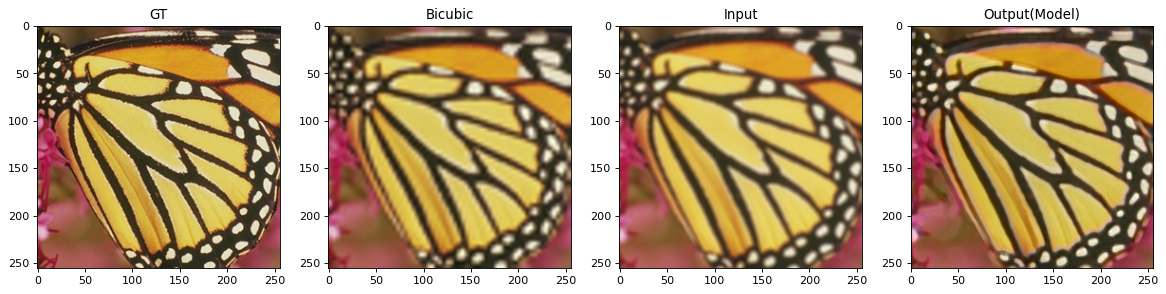

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7FA709A80AC0>,
 20.824648960041763,
 14.307158872250042)

In [48]:
display_PSNR(im_gt, im_b, im_b2, model)


In [ ]:
im_gt.size

In [49]:
# Make this load still photos too, and have them added with frame = 0
def test_results(test_dir,scale, display = False):
    instances = []
    psnr_bicubic_sum = 0
    psnr_model_sum = 0
    ct = 0
    
    for filename in listdir(test_dir):
        filepath = os.path.join(test_dir,filename)
        #print(filepath)
                
        if is_image_file(filepath):
            im_gt = Image.open(filepath).convert("RGB")
            #print(im_gt.size)
            
            (height, width) = im_gt.size
            im_b = im_gt.resize((int(height/scale), int(width/scale)), resample = Image.BICUBIC)
            im_b = im_b.resize((height,width), resample = Image.BICUBIC)
            im_b2 = Crappify(crop_size = None, kernel_size=scale*2, quality=90)(im_gt)# open image file
            im_h, psnr_bicubic, psnr_predicted = display_PSNR(im_gt, im_b, im_b2, model, display = display)
            psnr_bicubic_sum = psnr_bicubic_sum + psnr_bicubic
            psnr_model_sum = psnr_model_sum + psnr_predicted
            ct = ct +1
            #item = {"Filepath":filepath, "Type":"image"}
            #instances.append(item)
        
    psnr_bicubic_avg = psnr_bicubic_sum / ct
    psnr_model_avg = psnr_model_sum / ct
        
    print("Bicubic average PSNR =",psnr_bicubic_avg)
    print("Model average PSNR =",psnr_model_avg)
    return 



psnr for bicubic is 26.005048346240617dB
psnr for Model is 24.514003690760045dB
PSNR improvement is -1.4910446554805716dB
Sharpness Measurement GroundTruth: 247.28295878820063
Sharpness Measurement Bicubic: 2.681060552597046
Sharpness Measurement Input: 4.220924351771828
Sharpness Measurement Model: 19.429947044700384


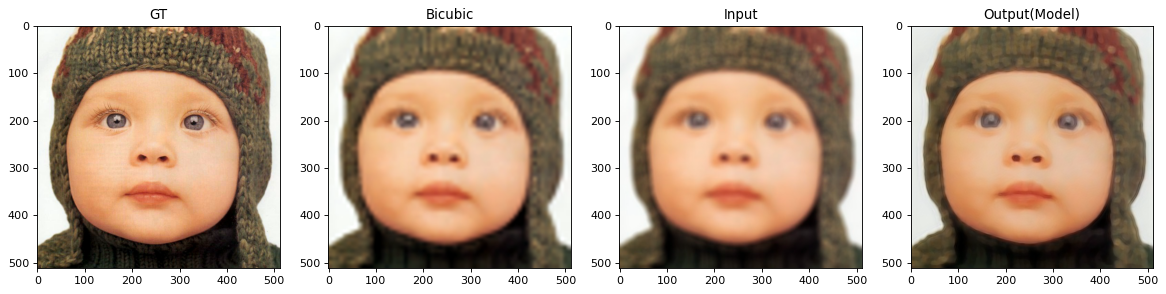

psnr for bicubic is 21.136632908652775dB
psnr for Model is 20.92617034351362dB
PSNR improvement is -0.2104625651391565dB
Sharpness Measurement GroundTruth: 726.1960912189749
Sharpness Measurement Bicubic: 4.587699582818501
Sharpness Measurement Input: 6.40578804101781
Sharpness Measurement Model: 46.5286271257776


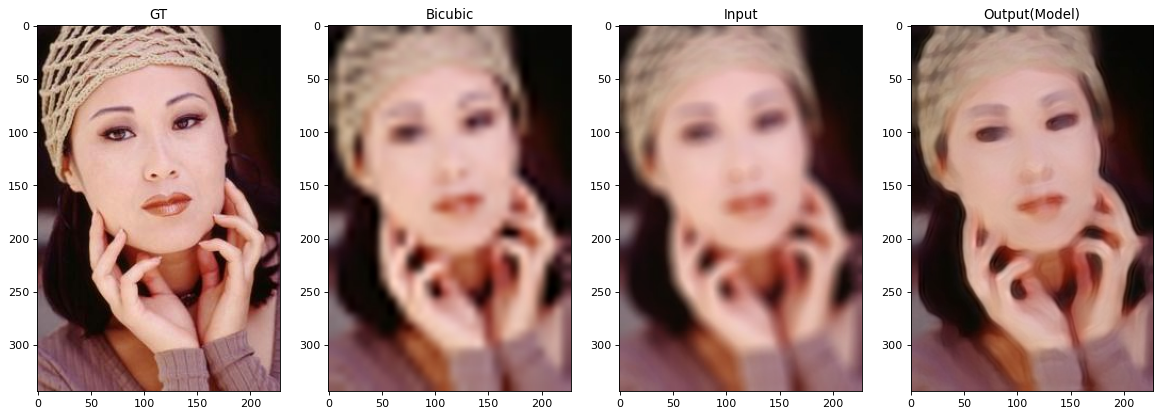

psnr for bicubic is 16.493948514416658dB
psnr for Model is 16.33166693284259dB
PSNR improvement is -0.16228158157406725dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 9.615642953431234
Sharpness Measurement Input: 10.551986627047881
Sharpness Measurement Model: 62.24878046452068


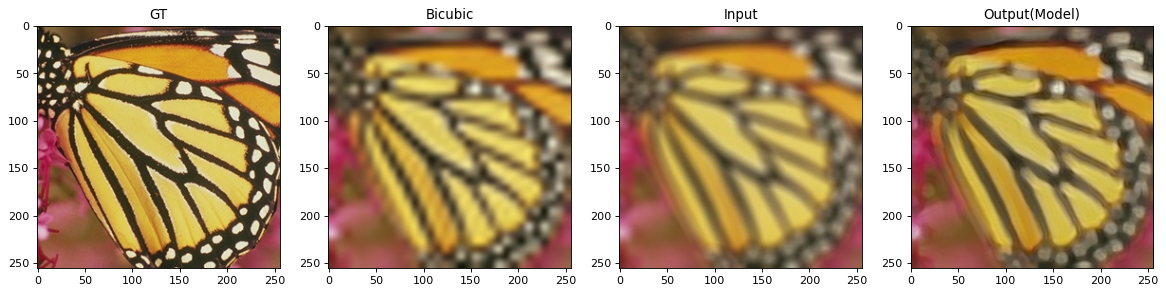

psnr for bicubic is 27.952862773840856dB
psnr for Model is 26.952622553751027dB
PSNR improvement is -1.0002402200898288dB
Sharpness Measurement GroundTruth: 593.2631865654935
Sharpness Measurement Bicubic: 2.395357077780091
Sharpness Measurement Input: 3.622704002889421
Sharpness Measurement Model: 9.92383403383356


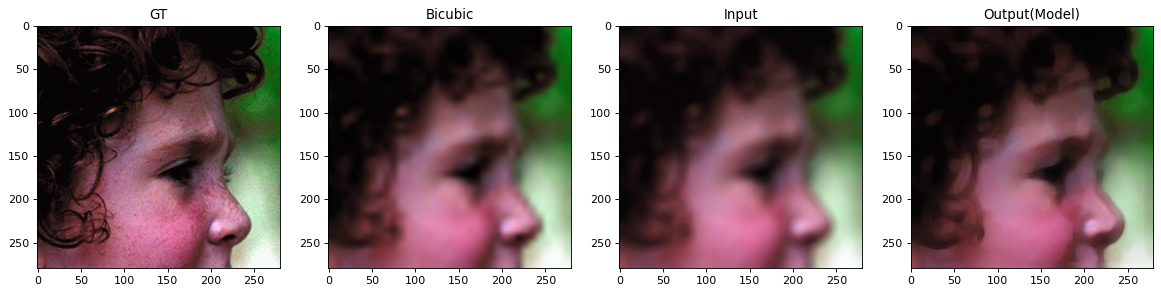

psnr for bicubic is 23.880224093124287dB
psnr for Model is 23.506002944060015dB
PSNR improvement is -0.3742211490642724dB
Sharpness Measurement GroundTruth: 233.21159694144288
Sharpness Measurement Bicubic: 3.947036537195993
Sharpness Measurement Input: 6.287554767069666
Sharpness Measurement Model: 22.937464018090434


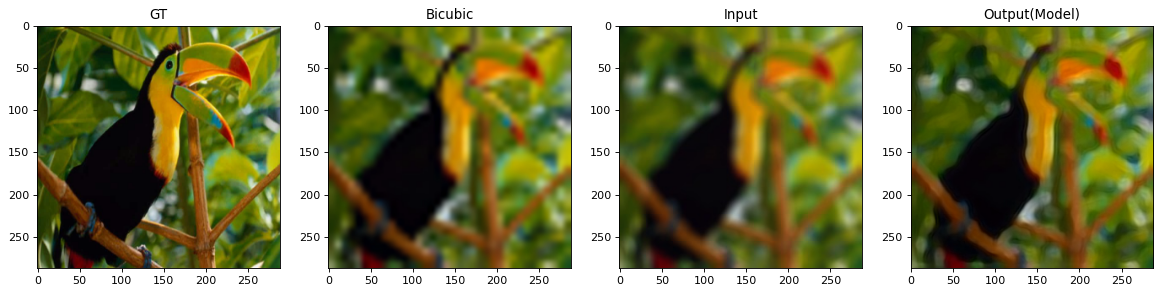

Bicubic average PSNR = 23.093743327255037
Model average PSNR = 22.44609329298546


In [76]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 8, display = True)

# convert sample videos

In [51]:
folder = "/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/"

infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30sechresperfuzmodel2-16.mp4"
superres_mp4(infile, outfile, model, factor=1.6,display=False,bitrate= "4000k")

  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/muffins30sechresperfuzmodel2-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [00:28<00:00, 31.68it/s]


True

In [52]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30sechresperfuzmodel2-10.mp4"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k")

  1%|          | 11/900 [00:00<00:08, 103.49it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/muffins30sechresperfuzmodel2-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:08<00:00, 109.18it/s]


True

In [53]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30sechresperfuzmodel2-20.mp4"
superres_mp4(infile, outfile, model, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 3/900 [00:00<00:32, 27.86it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/muffins30sechresperfuzmodel2-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [00:38<00:00, 23.25it/s]


True

In [54]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30sechresperfuzmodel2-30.mp4"
superres_mp4(infile, outfile, model, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/muffins30sechresperfuzmodel2-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [01:14<00:00, 12.13it/s]


True

In [55]:
dualfile= folder + "muffins30sechresperfuzmodel2-30dual.mp4"

In [56]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [57]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [58]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = folder + "super8hresperfuzmodel2.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/super8hresperfuzmodel2.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [04:34<00:00, 26.22it/s]


True

In [59]:

dualfile= folder + "super8hresperfuzmodel2dual.mp4"

In [60]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [61]:
# compare this model to the last one
infile = folder + "super8hresperfuzmodel2.mp4"
outfile = folder + "super8hresperfuzmodel2.mp4"
dualfile= folder + "super8hresperfuzmodel2-tolast-dual.mp4"

In [62]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [63]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = folder + "super8longhresperfuzmodel2.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

  0%|          | 2/121409 [00:00<1:49:33, 18.47it/s]

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/super8longhresperfuzmodel2.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 121409/121409 [1:15:18<00:00, 26.87it/s]


True

In [64]:
dualfile= folder + "super8longhresperfuzmodel2dual.mp4"

In [65]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [ ]:
def dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file):
    
    superres_mp4(infile, outfile, model, factor=factor,display=False,bitrate="4000k",errorfile = error_file)
    
    # original scale , for film x1, removed un needed scaling
    !ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = folder + "super8percepmodel2.mp4"
outfile = folder + "super8percepmodel2x2.mp4"
dualfile= folder + "super8percepmodel2x2x1dual.mp4"
error_file = "/media/SSD/superres/error.txt"

dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file)

infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
dualfile= folder + "super8percepmodel2x2origdual.mp4"

!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}